In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Normal
from distributions import logNormal
from build_dataset import build_dataset_1dim_ugm
import time
font = {'family': 'serif','color':  'black','weight': 'normal','size': 16,}

In [2]:
def bbvi_1dim_ugm(batch_size,x_data,n_iter,lam_m_init,lam_a_init,lam_b_init):
    start_time = time.time()
    #generative model 
    mu= Normal(loc=tf.constant(1.0),scale=tf.constant(0.5))
    sigma=logNormal(loc=tf.constant(1.0),scale=tf.nn.softplus(tf.constant(1.0)))
    x = Normal(loc=mu, scale= sigma,sample_shape=batch_size) 
    #variational model
    lambda_m = tf.Variable(lam_m_init)
    lambda_s  = tf.nn.softplus(tf.Variable(1.00)) 
    qmu = Normal(loc=lambda_m, scale=lambda_s) 
    
    lambda_a = tf.Variable(lam_a_init)
    lambda_b = tf.nn.softplus(tf.Variable(lam_b_init))
    qsigma = logNormal(loc=lambda_a,scale=lambda_b)


    latent_vars ={mu:qmu,sigma:qsigma}
    
    x_ph = tf.placeholder(tf.float32,[batch_size])
    data = {x:x_ph} 
    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter)
    print(time.time()-start_time)
    sess=ed.get_session()
    tf.global_variables_initializer().run()
    loss=[]
    variational_parameter = []
    variational_parameter.append(sess.run([lambda_m,
                                                                           lambda_s,
                                                                           lambda_a,
                                                                           lambda_b]))
    for _ in range(inference.n_iter):
        start = 0
        end = start+batch_size
        while(end <= len(x_data)):
            info_dict = inference.update(feed_dict = {x_ph:x_data[start:end]})
            start = end
            end =end+batch_size

        loss.append(info_dict['loss'])
        variational_parameter.append(sess.run([lambda_m,
                                                                               lambda_s,
                                                                               lambda_a,
                                                                               lambda_b]))
    print(time.time()-start_time)       
    return loss,variational_parameter

In [20]:
data_size=3000
mu_true=10.0
sigma_true=0.75
x_data=build_dataset_1dim_ugm(data_size,mean=mu_true,std=sigma_true)
batch_size=1000
iteration = 1000

loss,variational_parameter = bbvi_1dim_ugm(batch_size,x_data,iteration,14.0,1.0,1.0)

0.5196716785430908
7.516899108886719


<IPython.core.display.Javascript object>


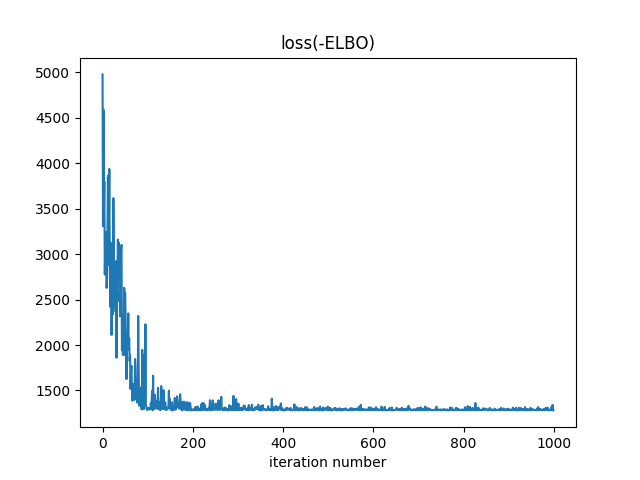

In [21]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()

<IPython.core.display.Javascript object>


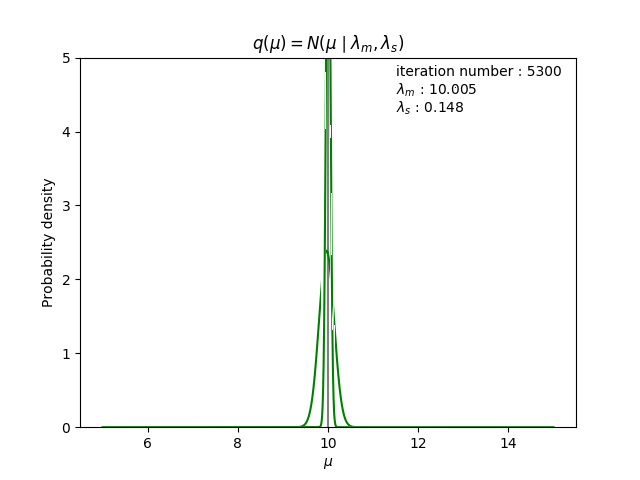

In [14]:
%matplotlib nbagg
from scipy.stats import norm
grid = np.linspace(start=5.0,stop=15.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu)=N(\mu\mid\lambda_m,\lambda_s)$")
plt.xlabel("$\mu$")
plt.ylabel("Probability density")
plt.axvline(x=mu_true,color="gray")
plt.ylim(0.0,5.0)
artists = []
for t,vp in enumerate(variational_parameter):
    if t%100 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=vp[1]),color="green")
        text = [plt.text(11.5,4.75,"iteration number : "+str(t)),
                     plt.text(11.5,4.50,"$\lambda_m$ : {0:.3f}".format(vp[0])),
                     plt.text(11.5,4.25,"$\lambda_s$ : {0:.3f}".format(vp[1]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu_ex1.gif", writer='imagemagick', fps=4)


<IPython.core.display.Javascript object>


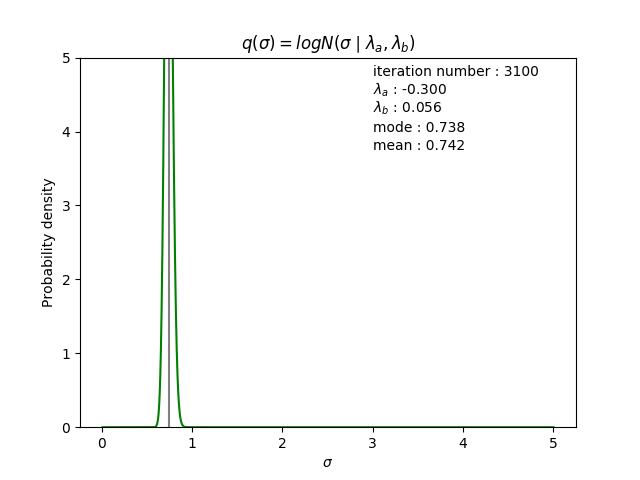

In [9]:
%matplotlib nbagg
grid = np.linspace(0.01, 5.0, 10000)
fig = plt.figure()
plt.title("$q(\sigma)=logN(\sigma\mid\lambda_a,\lambda_b)$")
plt.xlabel("$\sigma$")
plt.ylabel("Probability density")
plt.axvline(x=sigma_true,color="gray")
plt.ylim(0.0,5.0)
artists = []

for t,vp in enumerate(variational_parameter):
    if t%100 == 0:
        mu=vp[2]
        sigma=vp[3]
        pdf = (np.exp(-(np.log(grid) - mu)**2 / (2 * sigma**2))/ (grid * sigma * np.sqrt(2 * np.pi)))
        im = plt.plot(grid,pdf,color="green")
        text = [plt.text(3.0,4.75,"iteration number : "+str(t)),
                plt.text(3.0,4.50,"$\lambda_a$ : {0:.3f}".format(vp[2])),
                plt.text(3.0,4.25,"$\lambda_b$ : {0:.3f}".format(vp[3])),
                plt.text(3.0,4.00,"mode : {0:.3f}".format(np.exp(vp[2]-vp[3]**2))),
                plt.text(3.0,3.75,"mean : {0:.3f}".format(np.exp(vp[2]+vp[3]**2/2)))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig, artists)
plt.show()
#ani.save("sigma_ex1.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


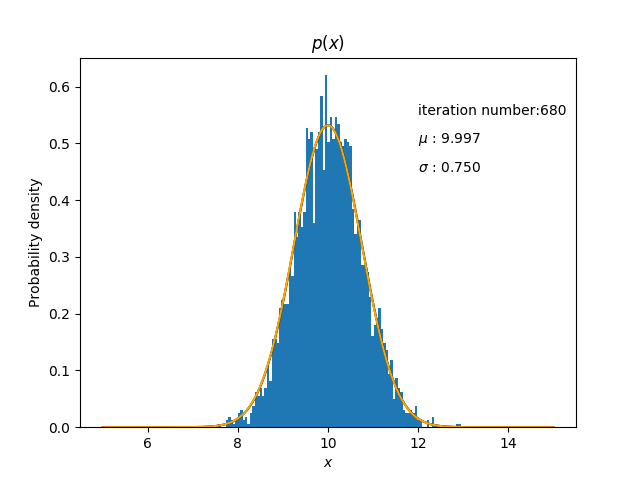

In [22]:
from scipy.stats import norm,lognorm
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=15.0,num=10000)
fig = plt.figure()
plt.title("$p(x)$")
plt.xlabel("$x$")
plt.ylabel("Probability density")
artists = []
plt.plot(grid,norm.pdf(x=grid,loc=mu_true,scale=sigma_true),color="black")
plt.hist(x_data,bins=100,density=True)
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=np.exp(vp[2])),color="orange")
        text = [plt.text(12,0.55,"iteration number:"+str(t)),
                     plt.text(12,0.50,"$\mu$ : {0:.3f}".format(vp[0])),
                     plt.text(12,0.45,"$\sigma$ : {0:.3f}".format(np.exp(vp[2])))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("result_ex1.gif", writer='imagemagick', fps=4)